# Computational Intelligence
# Lab: Genetic Programming (GP)

## Outline
1. Symbolic regression:
  - `TestCase` class
  - `Function` class
  - `TestCaseGenerator` class
2. Linear program: representation and execution
  - `Instruction` class
  - `Individual` class
  - `Population` class
  - `Evaluator` class
3. Reproduction-related classes
  - `Selection` class
  - `Crossover` class
  - `Mutation` class
  - `Breeder` class
4. Linear genetic programming
  - `ParameterSet` class
  - `LGP` class

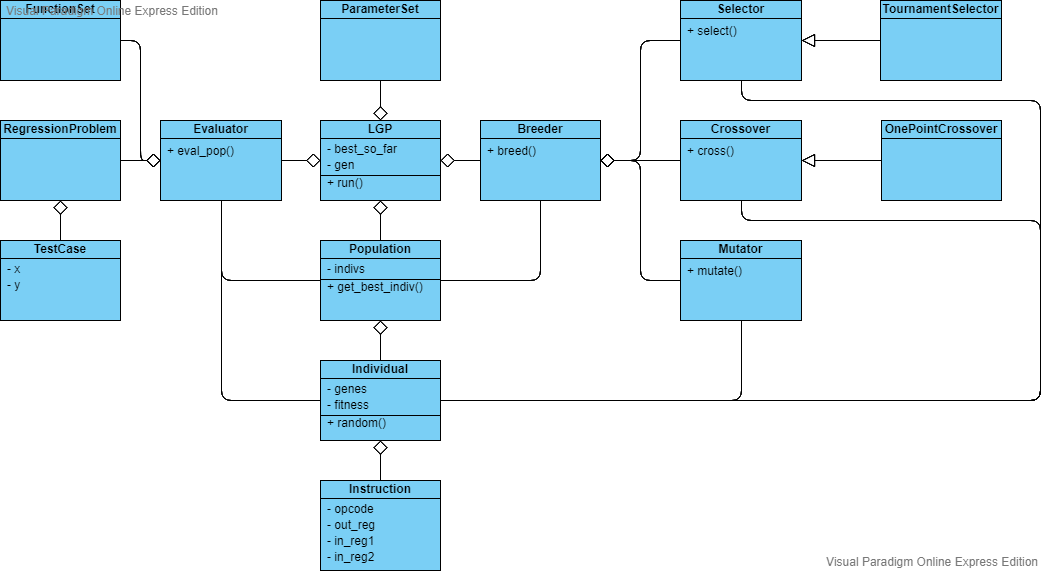

## 1. Symbolic regression

## The `TestCase` class

In [1]:
class TestCase:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __str__(self):
        return "x: " + str(self.x) + ", y: " + str(self.y)

In [2]:
tc1 = TestCase(10, 1)
tc2 = TestCase([1, 2, 5], 0.2)

print(tc1)
print(tc2)

x: 10, y: 1
x: [1, 2, 5], y: 0.2


## The `Function` class

In [3]:
# ----------------------------
# Base class: Function
# ----------------------------
class Function:
    def __init__(self):
        self.fn = "20 * np.sin(x[0]) + 10 * np.cos(x[1]) - 0.5 * x[0] * x[1]"   # Function (represetned as a string)
        self.domain = [[-3.0, 3.0], [3.0, 5.0]]
    
    def evaluate(self, x):
        return eval(self.fn)            # Convert string into expression and evaluate
    
    def get_num_var(self):
        return len(self.domain)
    
    def print(self):
        print("--------------------------")
        print("Function:", self.fn)
        print("Number of variables:", self.get_num_var())
        print("Domain:", self.domain)
        print("--------------------------")
        
    def __str__(self):
        return self.fn.replace("np.", "") # To remove "np."

# ----------------------------
# Derived class: Simple1DFunction
# ----------------------------
class TestFunction1D(Function):
    def __init__(self):
        #self.fn = "np.sin(20 * np.pi * x) + np.cos(6 * np.pi * x)"
        #self.domain = [[-.5, .5]]
        self.fn = "x * x - x + 1"
        self.domain = [[-10, 10]]

## The `TestCaseGenerator` class

In [4]:
import numpy as np
class TestCaseGenerator:
    def __init__(self, fn):
        self.fn = fn
        
    def generate(self, num_test_cases):
        test_case_list = []
        for i in range(num_test_cases):
            x, y = self._gen_a_test_case()
            test_case_list.append(TestCase(x, y))
        return test_case_list
    
    def _gen_a_test_case(self):
        num_vars = self.fn.get_num_var()
        x = np.zeros(num_vars)
        for i in range(len(x)):
            x[i] = np.random.uniform(self.fn.domain[i][0], self.fn.domain[i][1])
        y = self.fn.evaluate(x)
        return x, y

x: [-0.38007073], y: [1.52452448]
x: [-6.18304761], y: [45.41312531]
x: [-9.70477875], y: [104.88750926]
x: [-5.15189269], y: [32.69389094]
x: [0.93854947], y: [0.94232564]
x: [-6.85264848], y: [54.81143963]
x: [-0.76516014], y: [2.35063018]
x: [3.1270095], y: [7.65117889]
x: [-6.93630472], y: [56.04862794]
x: [-2.18842682], y: [7.97763879]
x: [1.00738761], y: [1.00744219]
x: [0.96413918], y: [0.96542518]
x: [6.87367999], y: [41.3737966]
x: [-3.79893716], y: [19.23086073]
x: [2.78398895], y: [5.96660555]
x: [6.43855409], y: [36.01642471]
x: [3.9890664], y: [12.92358437]
x: [-7.30790114], y: [61.7133202]
x: [4.10516191], y: [13.74719241]
x: [1.11564874], y: [1.12902337]
x: [9.77151964], y: [86.7110765]
x: [1.0895449], y: [1.09756318]
x: [2.70368939], y: [5.60624694]
x: [-5.87643246], y: [41.4088909]
x: [-4.48747809], y: [25.62493766]
x: [-2.26662558], y: [8.40421707]
x: [8.76933152], y: [69.13184377]
x: [8.31674041], y: [61.85143065]
x: [1.83025905], y: [2.51958913]
x: [7.04914126], y: 

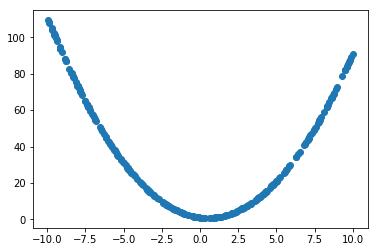

In [27]:
gen = TestCaseGenerator(fn=TestFunction1D())
test_cases = gen.generate(300)
for tc in test_cases:
    print(tc)
    
import matplotlib.pyplot as plt

x = [tc.x for tc in test_cases]
y = [tc.y for tc in test_cases]
plt.scatter(x, y)

## 2. Linear program: representation and execution

In [6]:
import numpy as np

## The `Instruction` class

In [7]:
LARGEST_RAND    = 100

class Instruction:
    def __init__(self, code=None):
        if code == None:
            self.random()
        else:
            self.set(code)
            
    def set(self, code):
        self.opcode = code[0]
        self.out_reg = code[1]
        self.in_reg1, self.in_reg2 = code[2], code[3]
        
    def random(self):
        self.set(np.random.randint(LARGEST_RAND, size=4))
        
    def __str__(self):
        return "[" + str(self.opcode) + " " + str(self.out_reg) + " " + \
               str(self.in_reg1) + " " + str(self.in_reg2) + "]"

In [8]:
instr1 = Instruction([13, 2, 4, 5])
print(instr1.opcode)
print(instr1.out_reg)
print(instr1.in_reg1)
print(instr1.in_reg2)
print(instr1)

13
2
4
5
[13 2 4 5]


## The `Individual` class

In [9]:
DEFAULT_FITNESS = 0

class Individual:
    def __init__(self, num_instrs):
        self.genes = [Instruction() for i in range(num_instrs)]
        self.fitness = DEFAULT_FITNESS
        #self.random()

    def get_length(self):
        return len(self.genes)
        
    def random(self):
        for i in range(self.get_length()):
            self.genes[i].random()
        
    def is_better_than(self, other):
        return self.fitness > other.fitness # Suppose "the larger fitness, the better individual" is true.
        
    def __str__(self):
        return "gene = " + "".join(str(g) for g in self.genes) + ", fit = " + str(format(self.fitness, "10.4f"))

In [10]:
indiv = Individual(5)
indiv.fitness = 10
print(indiv)

gene = [42 65 77 56][9 1 7 84][43 50 26 28][13 96 97 78][16 41 34 71], fit =    10.0000


## The `Population` class

In [11]:
class Population:
    def __init__(self, size, num_instrs):
        self.indivs = [Individual(num_instrs) for i in range(size)]

    def get_pop_size(self):
        return len(self.indivs)

    def get_best_indiv(self):
        best = self.indivs[0]
        for i in self.indivs:
            if i.is_better_than(best):
                best = i
        return best

    def print(self):
        for p in self.indivs:
            print(p)

In [12]:
pop = Population(10, 5)
pop.indivs[3].fitness = 5
pop.indivs[6].fitness = 7
pop.indivs[8].fitness = -10
pop.print()

print("Best", pop.get_best_indiv())

gene = [23 6 58 1][95 65 14 41][98 0 47 40][60 66 19 97][92 34 23 59], fit =     0.0000
gene = [2 64 49 88][22 53 21 84][30 58 89 83][48 94 41 80][41 76 86 58], fit =     0.0000
gene = [94 17 16 60][13 72 88 40][73 55 58 46][43 96 97 23][23 53 43 82], fit =     0.0000
gene = [32 23 23 55][64 6 55 72][46 27 3 16][72 52 17 45][50 53 86 32], fit =     5.0000
gene = [42 69 43 55][22 45 0 73][12 86 76 34][80 5 66 18][71 26 7 26], fit =     0.0000
gene = [10 80 95 98][56 39 70 5][2 68 40 87][90 35 15 55][4 77 2 0], fit =     0.0000
gene = [13 93 28 8][38 63 89 51][60 95 2 74][84 58 41 96][89 66 24 89], fit =     7.0000
gene = [69 93 77 43][80 50 83 14][40 39 51 19][27 86 34 62][43 39 11 26], fit =     0.0000
gene = [41 80 61 34][61 1 55 76][42 3 30 40][38 44 22 1][86 20 64 46], fit =   -10.0000
gene = [45 73 6 89][48 21 80 53][90 1 74 57][49 28 32 61][54 33 18 7], fit =     0.0000
Best gene = [13 93 28 8][38 63 89 51][60 95 2 74][84 58 41 96][89 66 24 89], fit =     7.0000


## The `Evaluator` class

In [13]:
num_test_cases = 100
test_cases = gen.generate(num_test_cases)

from math import sin, cos
primitives = [["ADD", "reg[out] = reg[in1] + reg[in2]"], \
              ["SUB", "reg[out] = reg[in1] - reg[in2]"], \
              ["MUL", "reg[out] = reg[in1] * reg[in2]"], \
              ["DIV", "if reg[in2] == 0:\n    reg[out] = 1\nelse:\n    reg[out] = reg[in1] / reg[in2]"], \
              ["SIN", "reg[out] = sin(reg[in1])"], \
              ["COS", "reg[out] = cos(reg[in1])"]]

# primitives = {"ADD" : "reg[out] = reg[in1] + reg[in2]", \
#               "SUB" : "reg[out] = reg[in1] - reg[in2]", \
#               "MUL" : "reg[out] = reg[in1] * reg[in2]", \
#               "DIV" : "if reg[in2] == 0:\n    reg[out] = 1\nelse:\n    reg[out] = reg[in1] / reg[in2]", \
#               "SIN" : "reg[out] = sin(reg[in1])", \
#               "COS" : "reg[out] = cos(reg[in1])"}

num_regs = 8
registers = np.zeros(num_regs)

In [14]:
class Evaluator:
    def __init__(self, primitives, test_cases, num_regs):
        #self.params = params
        self.num_regs = num_regs
        self.registers = np.zeros(self.num_regs)
        self.primitives = primitives
        self.num_primitives = len(primitives)
        
    def eval_pop(self, pop):
        for indiv in pop.indivs:
            x, f = self.eval_indiv(indiv)

    def eval_indiv(self, indiv):
        sum_sq_err = 0.0
        for tc in test_cases:
            y = self._execute(indiv.genes, tc.x)
            sum_sq_err += (tc.y - y) ** 2 
        #indiv.fitness = float(-sum_sq_err / len(test_cases))
        indiv.fitness = float(-sum_sq_err)
        return x, indiv.fitness
    
    def decode_indiv(self, indiv):
        program = ""
        for instr in indiv.genes:
            opcode, out, in1, in2 = self._decode_instr(instr)
            line = (primitives[opcode][1] + "\n")
            line = line.replace("out", str(out))
            line = line.replace("in1", str(in1))
            line = line.replace("in2", str(in2))
            program += line
        return program
    
    def _execute(self, genes, x):
        self._reset_reg(x)
        reg = self.registers
        for instr in genes:
            opcode, out, in1, in2 = self._decode_instr(instr)
            exec(self.primitives[opcode][1])
        return reg[0]
    
    def _reset_reg(self, x):
        for i in range(len(self.registers)):
            self.registers[i] = 1
        for i in range(len(x)):
            self.registers[i] = x[i]
    
    def _decode_instr(self, instr):
        instr.opcode %= self.num_primitives
        instr.out_reg %= self.num_regs
        instr.in_reg1 %= self.num_regs
        instr.in_reg2 %= self.num_regs
        return instr.opcode, instr.out_reg, instr.in_reg1, instr.in_reg2

In [15]:
evl = Evaluator(primitives, test_cases, num_regs)
evl.eval_pop(pop)
pop.print()

print("Best", pop.get_best_indiv())

gene = [5 6 2 1][5 1 6 1][2 0 7 0][0 2 3 1][2 2 7 3], fit = -263389.3354
gene = [2 0 1 0][4 5 5 4][0 2 1 3][0 6 1 0][5 4 6 2], fit = -263389.3354
gene = [4 1 0 4][1 0 0 0][1 7 2 6][1 0 1 7][5 5 3 2], fit = -244530.1062
gene = [2 7 7 7][4 6 7 0][4 3 3 0][0 4 1 5][2 5 6 0], fit = -263389.3354
gene = [0 5 3 7][4 5 0 1][0 6 4 2][2 5 2 2][5 2 7 2], fit = -263389.3354
gene = [4 0 7 2][2 7 6 5][2 4 0 7][0 3 7 7][4 5 2 0], fit = -237164.7884
gene = [1 5 4 0][2 7 1 3][0 7 2 2][0 2 1 0][5 2 0 1], fit = -263389.3354
gene = [3 5 5 3][2 2 3 6][4 7 3 3][3 6 2 6][1 7 3 2], fit = -263389.3354
gene = [5 0 5 2][1 1 7 4][0 3 6 0][2 4 6 1][2 4 0 6], fit = -239388.7267
gene = [3 1 6 1][0 5 0 5][0 1 2 1][1 4 0 5][0 1 2 7], fit = -263389.3354
Best gene = [4 0 7 2][2 7 6 5][2 4 0 7][0 3 7 7][4 5 2 0], fit = -237164.7884


In [16]:
program = evl.decode_indiv(pop.indivs[2])
print(program)

reg = np.ones(num_regs)
x = 3
reg[0] = x
exec(program)
y = reg[0]
print("x = %d, y = %d" % (x, y))

reg[1] = sin(reg[0])
reg[0] = reg[0] - reg[0]
reg[7] = reg[2] - reg[6]
reg[0] = reg[1] - reg[7]
reg[5] = cos(reg[3])

x = 3, y = 0


## 3. Reproduction-related classes

## The `Selector` class and `TournametSelector` class


In [17]:
import random
# ----------------------------
# Base class: Selector
# ----------------------------
class Selector:
    def select(self, pop):                  # Just random selection
        size = pop.get_pop_size()
        rd = random.randint(0, size - 1)
        return pop.indivs[rd]

# ----------------------------
# Derived class: TournamentSelector
# ----------------------------
class TournamentSelector(Selector):
    def __init__(self, tournament_size):
        super().__init__()
        self.ts = tournament_size

    def select(self, pop):
        size = pop.get_pop_size()
        rd = random.randint(0, size - 1)
        best_idx = rd;
        
        for i in range(1, self.ts):
            rd = random.randint(0, size - 1)
            if pop.indivs[rd].is_better_than(pop.indivs[best_idx]):
                best_idx = rd;

        return pop.indivs[best_idx]
#----------------------------

## The `Crossover` class and `OnePointCrossover` class
- Simulate a breeding process
- That is, mixing DNAs of two parents to generate (usually two) offspring

In [18]:
import random
# ----------------------------
# Base class: Crossover
# ----------------------------
class Crossover:
    def __init__(self, pc):
        self.pc = pc

# ----------------------------
# Derived class: OnePointCrossover
# ----------------------------
class OnePointCrossover(Crossover):
    def __init__(self, pc):
        super().__init__(pc)

    def cross(self, p1, p2):
        rd = random.uniform(0, 1)
        if(rd < self.pc):
            cut_point = random.randint(1, p1.get_length() - 1)
            #print("cutPoint = ", cutPoint)
            p1.genes[cut_point:], p2.genes[cut_point:] = p2.genes[cut_point:], p1.genes[cut_point:]
        return p1, p2  

## The `Mutator` class
- For each instruction in the gene, generate a random number $rd \in [0, 1]$
- If the random number $rd$ is smaller than the mutation probability $p_m$, modify that instruction.
  - Replaced that instructio by a random instruction

In [19]:
# ----------------------------
# Base class: Mutator
# ----------------------------
class Mutator:
    def __init__(self, pm):
        self.pm = pm
        
    def mutate(self, p):
        for i in range(p.get_length()):
            rd = random.uniform(0,1)
            if rd < self.pm:
                p.genes[i].random()
        return p

## The `Breeder` class

In [20]:
from copy import deepcopy
class Breeder:
    def __init__(self, selector, crossover, mutator, elitism):
        self.selector = selector
        self.crossover = crossover
        self.mutator = mutator
        self.elitism = elitism

    def breed(self, parent_pop, offspring_pop):
        size = parent_pop.get_pop_size()

        count = 0
        while count < size:
            #selection
            p1 = deepcopy(self.selector.select(parent_pop))
            p2 = deepcopy(self.selector.select(parent_pop))
            
            #crossover
            q1, q2 = self.crossover.cross(p1, p2)
            
            #mutation
            o1 = self.mutator.mutate(q1)
            o2 = self.mutator.mutate(q2)
            
            #insert new individuals into the offspring popuation
            offspring_pop.indivs[count] = o1
            count += 1
            offspring_pop.indivs[count] = o2
            count += 1

        #elitist
        if self.elitism is True:
            offspring_pop.indivs[0] = deepcopy(parent_pop.get_best_indiv())

## 4. Linear genetic programming

## The `ParameterSet` class

In [21]:
class ParameterSet:
    def __init__(self):         # Assign default parameters (can be changed after an object is created)
        # Problem-related parameters
        self.is_maximize = True # Maximization problem or minimization problem
        
        # GA's parameters
        self.max_gen  = 20      # Maximum number of generations
        self.pop_size = 20      # Population size
        
        # Individual-related parameters
        self.num_instrs = 10

        # Evaluator-related parameters
        self.num_regs = 8
        
        # Breeder-related parameters
        self.ts = 2             # Tournament size
        self.pc = 0.9           # Crossover rate
        self.pm = 0.1           # Mutation rate
        self.elitism = True     # Elitism
        
    def print(self):
        print("--------------------------")
        print("Parameter Setting:")
        if self.is_maximize is True:
            print("Problem: Maximization")
        else:
            print("Problem: Minimization")
        print("Maximum number of generations =", self.max_gen)
        print("Population size =", self.pop_size)
        print("Number of instructions (fixed) =", self.num_instrs)
        print("Number of registers =", self.num_regs)
        print("Tournament size =", self.ts)
        print("Crossover rate =", self.pc)
        print("Mutation rate =", self.pm)
        print("Elitism =", self.elitism)
        print("--------------------------")

## The `LGP` class

In [22]:
import time

class LGP:
    def __init__(self, primitives, test_cases, params=ParameterSet()):
        # Create evaluator
        self.evaluator = Evaluator(primitives, test_cases, params.num_regs)

        # Parameter settings
        self.params = params
    
        # Create breeder
        selector = TournamentSelector(params.ts)
        crossover = OnePointCrossover(params.pc)
        mutator = Mutator(params.pm)
        self.breeder = Breeder(selector, crossover, mutator, params.elitism)
       
    def _reset(self):
        self.gen = 0
        self.best_so_far = None
        self.pop1 = Population(self.params.pop_size, self.params.num_instrs)
        self.pop2 = Population(self.params.pop_size, self.params.num_instrs)

    def _update_best_so_far(self, pop):
        current_best = pop.get_best_indiv()
        if self.best_so_far == None:
            self.best_so_far = deepcopy(current_best)
        elif current_best.is_better_than(self.best_so_far):
            self.best_so_far = deepcopy(current_best)

    def run(self):
        # Reset state
        self._reset()

        # Loop
        for self.gen in range(self.params.max_gen):
            # Evaluate current population
            self.evaluator.eval_pop(self.pop1)
            print("--------------------------")
            print("Generation:", self.gen)
            self.pop1.print()

            # Check best-so-far individual
            self._update_best_so_far(self.pop1)         
            print("Best-so-far:", self.best_so_far)
            
            # Breed offspring population
            self.breeder.breed(self.pop1, self.pop2)

            # Swap population
            self.pop1, self.pop2 = self.pop2, self.pop1

            # Delay
            time.sleep(0.5)
            
        return self.best_so_far

## Test the `LGP` class

In [28]:
# Create a set of parameters
params = ParameterSet()
# Adjust some parameters
params.is_maximize = True
params.max_gen = 30
params.pop_size = 20
params.num_regs = 4
params.num_instrs = 8
# Verify parameters
params.print()

--------------------------
Parameter Setting:
Problem: Maximization
Maximum number of generations = 30
Population size = 20
Number of instructions (fixed) = 8
Number of registers = 4
Tournament size = 2
Crossover rate = 0.9
Mutation rate = 0.1
Elitism = True
--------------------------


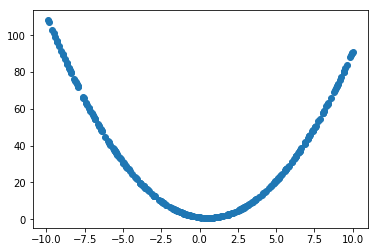

In [24]:
from math import sin, cos

primitives = [["ADD", "reg[out] = reg[in1] + reg[in2]"], \
              ["SUB", "reg[out] = reg[in1] - reg[in2]"], \
              ["MUL", "reg[out] = reg[in1] * reg[in2]"], \
              ["DIV", "if reg[in2] == 0:\n    reg[out] = 1\nelse:\n    reg[out] = reg[in1] / reg[in2]"], \
              ["SIN", "reg[out] = sin(reg[in1])"], \
              ["COS", "reg[out] = cos(reg[in1])"]]

gen = TestCaseGenerator(fn=TestFunction1D())
num_test_cases = 300
test_cases = gen.generate(num_test_cases)
import matplotlib.pyplot as plt

x = [tc.x for tc in test_cases]
y = [tc.y for tc in test_cases]
plt.scatter(x, y)

In [30]:
# Create an LGP object
lgp = LGP(primitives, test_cases, params)

# Then, run GA
best_indiv = lgp.run()

--------------------------
Generation: 0
gene = [5 3 3 3][5 1 0 0][0 1 0 2][2 2 0 2][1 2 2 3][0 1 1 2][5 0 3 1][5 1 1 2], fit = -648462.8936
gene = [0 1 3 3][5 1 1 0][5 2 2 3][0 1 0 3][2 3 1 3][4 2 3 2][1 2 0 3][3 2 1 3], fit = -708947.0181
gene = [3 0 3 3][0 3 3 2][1 2 3 2][1 3 1 1][4 0 0 3][1 3 2 1][4 2 1 3][0 0 0 2], fit = -631805.2958
gene = [3 1 0 3][1 2 3 1][3 2 1 2][2 2 1 3][2 0 2 0][1 1 3 1][0 3 3 0][3 0 1 0], fit = -2861571.2715
gene = [5 3 0 3][5 2 3 2][3 1 0 0][5 3 0 3][3 3 1 0][3 0 2 0][4 0 2 1][2 0 3 3], fit = -2986575.3920
gene = [4 1 1 0][2 0 3 3][4 3 3 0][5 2 0 1][5 0 3 0][2 2 1 3][2 1 3 0][5 3 0 1], fit = -652379.6334
gene = [5 0 3 0][3 0 1 2][1 0 0 3][0 3 3 3][2 1 1 3][0 2 1 0][3 0 3 0][4 1 2 0], fit = -645558.9164
gene = [4 2 1 2][2 3 3 3][5 3 1 0][5 1 3 0][3 1 0 2][4 3 0 3][3 1 0 3][3 1 2 3], fit = -708947.0181
gene = [1 3 2 2][3 2 1 1][1 3 3 2][0 3 2 0][0 2 0 3][5 0 1 2][1 0 0 2][0 2 3 2], fit = -650950.4230
gene = [5 2 0 3][0 1 3 2][0 2 1 0][0 3 0 2][5 0 1 3][4 1 

--------------------------
Generation: 4
gene = [3 0 3 3][0 3 3 1][0 1 1 0][5 1 3 2][0 0 2 3][1 3 2 1][1 3 2 1][0 0 0 2], fit = -587227.9172
gene = [3 0 3 3][0 3 3 1][2 2 1 3][5 1 3 2][0 0 2 3][2 2 3 2][5 2 1 2][5 0 0 0], fit = -680020.4518
gene = [1 0 3 2][2 1 3 2][5 0 0 2][2 3 1 3][1 0 2 3][2 3 0 0][2 3 3 2][3 0 1 1], fit = -645558.9164
gene = [0 0 1 1][0 0 2 0][2 2 1 3][0 2 1 1][5 0 0 3][1 3 2 1][4 2 1 3][0 0 0 2], fit = -669319.7854
gene = [3 0 3 3][0 3 3 1][2 2 1 3][5 1 3 2][0 0 2 3][1 3 2 1][4 2 1 3][0 0 0 2], fit = -594773.0160
gene = [4 1 1 0][2 0 3 3][4 3 3 0][3 2 3 1][1 3 1 0][1 3 2 1][4 2 1 3][0 0 0 2], fit = -630556.9743
gene = [3 0 3 3][0 3 3 2][2 1 2 2][2 1 2 3][0 0 2 3][2 1 0 0][5 2 1 2][0 0 3 2], fit = -643753.3495
gene = [3 0 3 3][0 3 0 2][2 2 1 3][5 1 3 2][4 0 0 3][1 3 2 3][3 1 0 3][3 1 2 3], fit = -648791.5173
gene = [3 0 3 3][0 3 3 1][1 2 3 2][2 1 2 3][4 0 0 3][3 1 2 3][5 2 1 2][0 0 3 2], fit = -608419.5980
gene = [3 0 3 3][0 3 3 2][2 2 1 3][5 1 3 2][0 0 2 3][3 1 3 

--------------------------
Generation: 8
gene = [3 0 3 3][0 3 3 2][2 2 1 3][5 1 3 2][0 0 2 3][1 3 2 1][5 0 1 2][0 0 3 2], fit = -579562.9826
gene = [0 0 1 1][0 3 3 2][5 2 0 1][2 0 0 1][4 0 0 3][1 1 0 3][5 1 2 0][0 0 3 2], fit = -633783.4678
gene = [3 0 3 3][0 3 3 1][2 3 3 2][5 1 3 2][1 1 1 3][1 3 2 1][2 3 3 2][0 0 3 2], fit = -579562.9826
gene = [3 0 3 3][0 3 3 1][0 1 1 0][5 1 3 2][0 0 2 3][1 3 2 1][5 2 1 2][1 2 2 3], fit = -606071.5836
gene = [3 0 3 3][0 3 3 1][0 1 1 0][5 1 3 2][1 1 1 3][1 3 2 1][2 3 3 2][0 0 0 2], fit = -625515.2500
gene = [3 3 3 1][0 3 3 1][0 1 1 0][5 1 3 2][0 0 2 3][1 3 2 1][1 3 2 1][0 0 3 2], fit = -617350.9392
gene = [3 0 3 3][0 3 3 1][0 1 1 0][5 1 3 2][1 1 1 3][1 3 2 1][1 3 2 1][0 0 0 2], fit = -625515.2500
gene = [3 0 3 3][0 3 3 1][0 1 1 0][5 1 3 2][0 0 2 3][1 3 2 1][2 3 3 2][0 0 3 2], fit = -617350.9392
gene = [3 0 3 3][0 3 3 2][5 3 3 1][5 1 3 2][0 0 2 3][1 3 2 1][1 3 2 1][0 0 3 2], fit = -643824.8374
gene = [3 0 3 3][0 3 3 1][2 2 3 0][5 1 3 2][0 0 2 3][1 3 2 

--------------------------
Generation: 12
gene = [3 0 3 3][0 3 3 1][2 2 3 0][5 1 3 2][1 1 1 3][1 3 2 1][2 3 3 2][1 0 3 1], fit = -468577.2214
gene = [4 3 1 2][0 3 3 1][2 2 3 0][5 1 3 2][5 2 0 1][1 3 2 1][2 3 3 2][1 0 3 1], fit = -650706.1738
gene = [3 0 3 3][0 3 0 3][2 2 3 0][5 1 3 2][0 0 2 3][3 1 2 0][1 3 2 1][0 0 0 2], fit = -551340.5844
gene = [4 0 1 0][0 3 3 1][2 2 3 0][5 1 3 2][0 0 2 3][3 1 2 0][1 3 2 1][0 0 0 2], fit = -562459.1128
gene = [3 0 3 3][0 3 3 2][2 2 1 3][5 1 3 2][0 0 2 3][4 1 3 1][1 3 2 1][4 2 3 2], fit = -587227.9172
gene = [3 0 3 3][0 3 3 1][2 2 3 0][5 1 3 2][0 0 2 3][1 3 2 1][2 3 3 2][2 1 2 3], fit = -587227.9172
gene = [3 0 3 3][0 3 3 1][0 1 1 0][5 1 3 2][0 0 2 3][1 3 2 1][2 3 3 2][1 0 3 1], fit = -628834.8254
gene = [3 0 3 3][0 3 3 1][2 2 3 0][5 1 3 2][1 1 1 3][1 3 2 1][2 3 3 2][3 2 0 2], fit = -645558.9164
gene = [4 0 1 0][0 3 3 1][2 2 3 0][5 1 3 2][0 0 2 3][3 1 2 0][0 3 1 0][0 0 0 2], fit = -562459.1128
gene = [3 0 3 3][0 3 0 3][2 2 3 0][5 1 3 2][0 0 2 3][3 1 2

--------------------------
Generation: 16
gene = [3 0 3 3][0 3 3 1][2 2 3 0][5 1 3 2][1 1 1 3][1 3 2 1][2 3 3 2][1 0 3 1], fit = -468577.2214
gene = [3 0 3 3][0 3 3 1][2 2 3 0][5 1 3 2][4 0 3 3][1 3 2 1][2 3 3 2][0 0 0 2], fit = -607810.4315
gene = [4 0 1 0][0 3 3 1][2 2 3 0][5 1 3 2][0 0 2 3][3 1 3 0][1 3 2 1][0 0 0 2], fit = -562459.1128
gene = [3 0 3 3][3 1 2 2][2 2 3 0][5 1 3 2][0 0 2 3][3 1 2 0][0 3 1 0][0 0 0 2], fit = -606071.5836
gene = [4 0 1 0][0 3 3 1][2 2 3 0][5 1 3 2][2 2 3 3][0 0 3 3][0 0 0 0][0 0 0 2], fit = -458078.5859
gene = [0 2 3 3][2 3 2 3][0 1 1 0][5 1 3 2][0 0 2 3][1 3 2 1][0 3 1 0][0 0 0 2], fit = -551340.5844
gene = [3 0 3 3][0 3 3 1][2 2 3 0][5 1 3 2][0 0 2 3][3 1 2 0][0 3 1 0][0 0 0 2], fit = -551340.5844
gene = [0 3 0 2][0 3 3 1][3 1 1 2][4 1 1 1][0 0 2 3][3 1 2 0][0 3 1 0][0 0 0 2], fit = -629476.9288
gene = [4 0 1 0][0 3 3 1][2 2 3 0][5 1 3 2][0 0 2 3][3 1 2 0][0 3 1 0][0 0 0 2], fit = -562459.1128
gene = [4 0 1 0][0 3 3 1][2 2 3 0][5 1 3 2][2 2 3 3][0 0 3

--------------------------
Generation: 20
gene = [0 1 0 1][0 3 3 1][2 2 3 0][5 1 3 2][1 1 1 3][3 0 3 3][2 3 3 2][0 0 0 2], fit = -90989.1472
gene = [4 0 1 0][0 3 3 1][0 1 1 0][5 1 3 2][2 2 3 3][0 0 3 3][0 0 0 0][0 0 0 2], fit = -458078.5859
gene = [3 2 1 0][0 3 3 1][2 2 3 0][5 1 3 2][2 2 3 3][4 0 1 1][2 3 3 2][0 0 0 2], fit = -594773.0160
gene = [0 1 0 1][0 3 3 1][1 2 1 0][5 3 2 3][1 1 1 3][3 0 3 3][0 0 0 0][0 0 0 2], fit = -606071.5836
gene = [4 0 1 0][0 3 3 1][2 2 3 0][5 1 3 2][1 1 1 3][0 0 3 3][0 3 1 0][0 0 0 2], fit = -556869.6908
gene = [3 2 2 3][0 3 3 1][2 2 3 0][5 1 3 2][2 2 3 3][0 0 3 3][0 0 0 0][0 0 0 2], fit = -458078.5859
gene = [4 2 2 3][0 3 3 1][2 2 3 0][2 3 0 2][1 1 1 3][3 0 3 3][4 1 3 1][0 0 0 2], fit = -751019.8856
gene = [0 1 0 1][0 3 3 1][1 2 1 0][5 1 3 2][2 2 3 3][0 0 3 3][0 0 0 0][0 0 0 2], fit = -842940.5890
gene = [0 1 0 1][0 3 3 1][3 0 1 2][1 2 0 1][1 1 1 3][3 0 3 3][2 3 3 2][0 0 0 2], fit = -645558.9164
gene = [0 1 0 1][0 3 3 1][2 2 3 0][5 3 2 3][1 1 1 3][3 0 3 

--------------------------
Generation: 24
gene = [1 3 3 0][0 3 3 1][1 1 2 3][5 1 3 2][2 2 3 3][3 1 2 0][3 1 3 0][0 0 0 2], fit = -43882.7565
gene = [1 0 3 0][0 3 3 1][2 2 3 0][5 1 3 2][2 2 3 3][0 0 3 3][0 0 0 0][0 0 0 2], fit = -458078.5859
gene = [1 3 3 0][0 3 3 1][1 1 2 3][1 0 3 0][0 1 0 2][1 2 2 0][4 1 3 2][0 0 0 2], fit = -645558.9164
gene = [1 0 3 0][0 3 3 1][1 1 2 3][5 1 3 2][2 2 3 3][3 1 2 0][3 1 3 0][0 0 0 2], fit = -547078.9056
gene = [0 0 0 1][0 3 3 1][2 2 3 0][5 1 3 2][2 2 3 3][0 0 3 3][0 0 0 0][0 0 0 2], fit = -458078.5859
gene = [1 3 3 0][0 3 3 1][1 1 2 3][1 0 3 0][0 1 2 3][3 1 2 0][3 1 3 0][0 0 0 2], fit = -581985.2801
gene = [4 0 1 0][0 3 3 1][1 1 2 3][5 1 3 2][2 2 3 3][0 0 3 3][0 0 0 0][0 0 0 2], fit = -458078.5859
gene = [1 0 3 0][0 3 3 1][1 0 3 3][5 1 3 2][2 2 3 3][3 1 2 0][3 1 3 0][0 0 0 2], fit = -587227.9172
gene = [4 3 0 3][0 3 3 1][1 1 2 3][5 1 3 2][3 2 2 0][0 0 3 3][0 0 0 0][0 0 0 2], fit = -597964.4417
gene = [1 3 3 0][0 3 3 1][1 1 2 3][5 1 3 2][2 2 3 3][3 1 2 

--------------------------
Generation: 28
gene = [1 3 3 0][1 0 2 0][1 1 2 3][5 1 3 2][2 2 3 3][3 1 2 0][5 0 3 3][0 0 0 2], fit = -9877.8806
gene = [1 0 3 0][5 2 2 1][2 2 3 0][5 1 3 2][2 2 3 3][0 0 3 3][3 1 3 0][0 0 0 2], fit = -606071.5836
gene = [5 0 3 0][1 0 2 0][1 1 2 3][5 3 0 1][2 2 3 3][3 1 2 0][5 0 3 3][0 0 0 2], fit = -636911.9434
gene = [1 1 2 3][3 0 3 1][1 1 2 3][1 1 2 1][2 2 3 3][0 0 3 3][0 0 0 0][0 0 0 2], fit = -568984.2508
gene = [1 0 3 0][1 0 2 0][1 1 2 3][5 1 3 2][2 2 3 3][2 1 2 3][5 0 3 3][0 0 0 2], fit = -634654.7646
gene = [1 3 3 0][0 3 3 1][0 3 3 2][5 1 3 2][2 2 3 3][0 0 3 3][0 0 0 0][0 0 0 2], fit = -961196.3902
gene = [1 0 3 0][5 2 2 1][4 1 2 3][5 1 3 2][2 2 3 3][0 0 3 3][0 0 0 0][0 0 0 2], fit = -568984.2508
gene = [1 3 3 0][1 1 2 3][1 1 2 3][5 1 3 2][0 2 2 2][3 1 2 0][0 0 0 0][4 2 1 1], fit = -771911.2639
gene = [1 3 3 0][1 0 2 0][1 1 2 3][5 1 3 2][0 2 2 2][1 2 1 2][0 0 0 0][0 0 0 2], fit = -644599.1102
gene = [2 2 2 0][1 0 2 0][1 1 2 3][5 1 3 2][2 2 3 3][3 1 2 0


The best individual founded by GP: gene = [3 3 0 1][1 0 2 0][1 1 2 3][5 1 3 2][2 2 3 3][3 1 2 0][3 1 3 0][0 0 0 2], fit =    -0.0000

Solution:
if reg[1] == 0:
    reg[3] = 1
else:
    reg[3] = reg[0] / reg[1]
reg[0] = reg[2] - reg[0]
reg[1] = reg[2] - reg[3]
reg[1] = cos(reg[3])
reg[2] = reg[3] * reg[3]
if reg[0] == 0:
    reg[1] = 1
else:
    reg[1] = reg[2] / reg[0]
if reg[0] == 0:
    reg[1] = 1
else:
    reg[1] = reg[3] / reg[0]
reg[0] = reg[0] + reg[2]



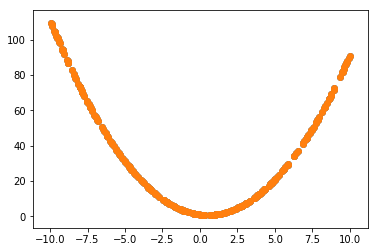

In [31]:
# Display result
print("\nThe best individual founded by GP:", best_indiv)

print("\nSolution:")
program = lgp.evaluator.decode_indiv(best_indiv)
print(program)

r = []
for tc in test_cases:
    result = lgp.evaluator._execute(best_indiv.genes, tc.x)
    r.append(result)
    
import matplotlib.pyplot as plt

x = [tc.x for tc in test_cases]
y = [tc.y for tc in test_cases]
plt.scatter(x, y)
plt.scatter(x, r)

In [ ]:
# Before execution
# reg[0] = x
# reg[1:] = 1

if reg[1] == 0: # False
    reg[3] = 1
else:
    reg[3] = reg[0] / reg[1]    # reg[3] <- x

reg[0] = reg[2] - reg[0]        # reg[x] <- 1 -x

# reg[1] = reg[2] - reg[3]

# reg[1] = cos(reg[3])

reg[2] = reg[3] * reg[3]        # reg[2] <- x * x

# if reg[0] == 0:
#     reg[1] = 1
# else:
#     reg[1] = reg[2] / reg[0]
    
# if reg[0] == 0:
#     reg[1] = 1
# else:
#     reg[1] = reg[3] / reg[0]
    
reg[0] = reg[0] + reg[2]        # reg[0] <- 1 - x + x * x

In [ ]:
reg[3] = reg[0] / reg[1]  # reg[3] = x / 1 = x
reg[0] = reg[2] - reg[0]  # reg[0] = 1 - x
reg[2] = reg[3] * reg[3]  # reg[2] = x * x
reg[0] = reg[0] + reg[2]  # reg[0] = (1 - x) + (x * x) = x * x - x + 1